In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, accuracy_score, recall_score, precision_score, f1_score, mean_squared_error
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

from sklearn.svm import LinearSVR

%matplotlib inline

In [10]:
df = pd.read_csv('AMZN_formatted.csv', index_col = 0)
df.dropna(inplace = True)

In [11]:
corrs = df.corr().stack().reset_index()
corrs.columns = ['1','2','R2']
temp = corrs[(corrs.R2 > .8) & (corrs.R2 < .999)].sort_values('R2', ascending = False).reset_index(drop = True)
correlations = temp[temp.index % 2 == 0]

In [12]:
correlations

,1,2,R2
0,RSI_oversold_cross,RSI_oversold,0.824428


In [13]:
X = df.shift(1).dropna()
y = df['adjustedclose'].iloc[1:]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 42, test_size = .2)

In [15]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

In [16]:
X_train_scaled

,low,open,volume,high,close,adjustedclose,rsi,BBB_5_2.0,BBP_5_2.0,ema7,...,RSI_oversold_cross,RSI_overbought,RSI_oversold,momentum,psr,ir,ffer,sp500_return,sp500_BBB_5_2.0,sp500_BBP_5_2.0
0,-1.018413,-1.018976,0.006899,-1.011380,-1.010681,-1.010681,-0.903262,-0.188409,-0.291709,-1.005188,...,-0.081969,-0.359718,-0.0977,-0.389647,-0.238152,0.233128,-0.723413,-0.081649,-0.587416,-1.328837
1,1.873340,1.839425,-0.691944,1.840627,1.867705,1.867705,-0.969779,0.055817,1.231498,1.832969,...,-0.081969,-0.359718,-0.0977,-0.300024,0.271993,-1.257092,-0.761378,0.081195,0.253480,0.835348
2,1.830345,1.851504,-0.562880,1.837311,1.797027,1.797027,-0.780709,0.030608,0.310953,1.807772,...,-0.081969,-0.359718,-0.0977,-1.003623,0.387935,-0.712315,-0.804189,-0.859409,0.521103,-0.240312
3,1.895825,1.892234,-0.843966,1.871324,1.881735,1.881735,-0.772218,0.166836,-1.334998,1.932610,...,-0.081969,-0.359718,-0.0977,0.667653,-0.330905,-0.774402,-0.777937,0.386728,-0.572637,1.081166
4,-0.659054,-0.656987,-0.164767,-0.660932,-0.666278,-0.666278,0.053528,0.517174,0.542124,-0.668546,...,-0.081969,-0.359718,-0.0977,-0.090109,-0.307717,0.290303,-0.575594,-1.472187,0.643091,-0.093137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793,0.593182,0.582712,-0.529470,0.580351,0.598228,0.598228,0.350706,-0.625741,-0.185990,0.602537,...,-0.081969,-0.359718,-0.0977,0.224329,-0.400470,-0.005835,2.131593,0.206417,-0.610224,-0.604891
1794,-0.370991,-0.373721,-0.755497,-0.382843,-0.376937,-0.376937,1.045726,-0.361041,0.769207,-0.382757,...,-0.081969,-0.359718,-0.0977,0.065641,-0.214963,0.388527,0.259219,0.113343,0.011129,0.817561
1795,-0.342739,-0.345300,-0.538429,-0.352744,-0.348964,-0.348964,0.091372,-0.446688,0.334720,-0.354223,...,-0.081969,-0.359718,-0.0977,-0.025939,-0.261340,0.411690,0.563743,0.116784,-0.469564,1.036103
1796,0.191519,0.178351,-0.080311,0.167901,0.181108,0.181108,1.290899,-0.176324,0.794831,0.162408,...,-0.081969,2.779956,-0.0977,0.585535,-0.261340,1.257324,1.008815,0.359949,-0.128257,0.737727


In [17]:
svr = LinearSVR(random_state = 42, max_iter = 10e5)

In [18]:
svrmodel = svr.fit(X_train_scaled, y_train)

In [19]:
train_score = svr.score(X_train_scaled, y_train)
y_hat_train = svr.predict(X_train_scaled)
train_rmse = mean_squared_error(y_train, y_hat_train, squared = False)
train_cv_score = cross_val_score(svrmodel, X_train_scaled, y_train, n_jobs = -1).mean()

print(f'Train Score : {train_score}')
print(f'Train RMSE : {train_rmse}')
print(f'Mean Train Cross-Validation Score: {train_cv_score}')

Train Score : 0.9969866807301546
Train RMSE : 57.12107539304222
Mean Train Cross-Validation Score: 0.9636408184746081


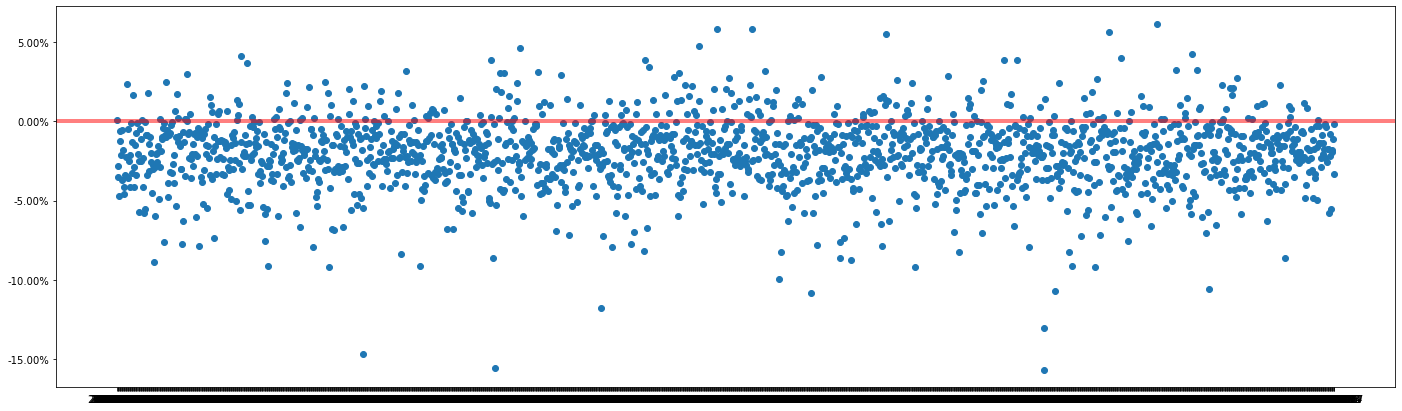

In [20]:
fig, ax = plt.subplots(figsize = (24,7))
plot_x = y_train.index
plot_y = (y_hat_train - y_train)/y_train
plt.scatter(plot_x,plot_y)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [21]:
test_score = svr.score(X_test_scaled, y_test)
y_hat_test = svr.predict(X_test_scaled)
test_rmse = mean_squared_error(y_test, y_hat_test, squared = False)

print(f'Test Score : {test_score}')
print(f'Test RMSE : {test_rmse}')

Test Score : 0.9971602128063767
Test RMSE : 56.34416578966727


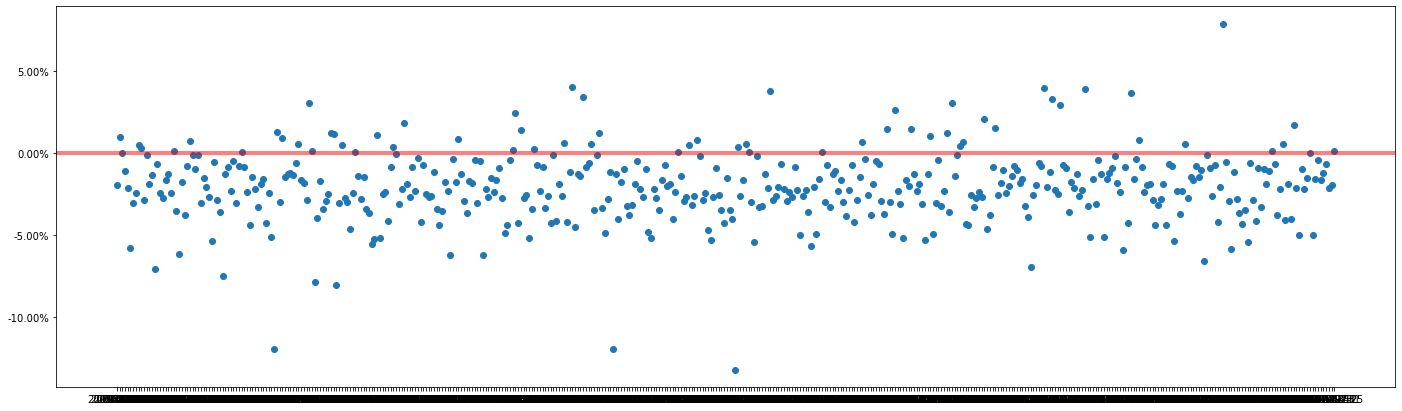

In [22]:
fig, ax = plt.subplots(figsize = (24,7))
ax.scatter(y_test.index, (y_hat_test - y_test)/y_test)
ax.yaxis.set_major_formatter('{x:1,.2%}')
plt.axhline(y=0, alpha = .5, color = 'red', linewidth = 4.0);

In [23]:
preds = pd.concat([y_train, pd.DataFrame(y_hat_train, columns = ['predictions'], index = y_train.index)], axis = 1)